# Predicting Political Party Affiliation of House Members based on Stock Transaction

**Lucas Papaioannou**

## Summary of Findings


### Introduction
The prediction problem my models will attempt to answer is "Given a transaction's data what is the political party of the congressmember that did that transaction?" 

This is a classification problem. Since I am only trying to classify only two classes this is a binary classification problem. 

The response variable of this model will be the party affiliation of the person who did the transaction. Since the dataset does not come with a column of party affiliation this would be a useful prediction tool if someone did not want to go through the effort of finding a dataset that has congressional districts and party affiliation. 

All the features that I train my models on will already be in the dataset at the time of prediction in a scenario like that I mentioned above. 

The metric I will use to evalutate my models is accuracy. In this prediction problem there are no adverse effects of false positives or false negatives so I only need to care about the percentage of correct predicitons. Because of this I chose accuracy over F1-score.

In order to increase the usability of the data and make this prediction quesiton testable I did the same data cleaning procedure that I did in project 3.

### Baseline Model
In the baseline model the features I used were the type of transaction happening and the type of owner of the account that is doing the transaction, respectively. These two features corrospond to the 'type' and 'owner' columns, respectively.

Both of these features are nominal so I used one-hot encoding using the OneHotEncoder from sklearn.

To implement this BaseLine model I used a DecisionTreeClassifier from sklearn. I used a max depth of 4 for the DecisionTreeClassifier as there are a small amount of features and I did not want to overfit to the training data.

To evaluate this model's ability to generalize on unseen data I tested it on a test set consisting of data the model has not seen. The accuracy of this model when tested on the test data is 64%. I consider this accuracy a good performance as if I used a naive model that just predicted what was the most common party in the dataset it would have an accuracy of 54.5%. Since this model achieves a higher accuracy than a naive model would it could be considered a good model.

### Final Model

I used the same features from the baseline model and added some more. The features I added were the Ticker of the stock in the transaction, the amount of money in the transaction, and if the transaction resulted in capital gains over 200 dollars. These features corrospond to the 'ticker','amount', and 'cap_gains_over_200_usd' columns, respectively. The ticker column is nominal so I used one-hot encoding on this column in the pipeline. The 'amount' and 'cap_gains_over_200_usd' columns are ordinal so I had to ordinal encode them. The 'cap_gains_over_200_usd' was already in a 1 or 0 format so I did not need to ordinal encode as it was essentially ordinally encoded already. But, I did implement a ordinal encoding on the 'amount' columns that transformed monetary ranges to discrete integers. 

These new features are good features to use as when I conducted EDA in project 3 and in the Baseline Model sections I noticed that there are disparities and sometimes big disparities in the categories of these features are grouped by 'party'. 

For this final model I decided to implement a RandomForestClassifier from sklearn. A RandomForestClassifier is made up of many DecisionTreeClassifers so in theory performance should be improved. To find the best possible parameters for this model I used a GridSearchCV from sklearn. The parameters that ended up performing the best for the RandomForestClassifer were 'criterion': 'gini', 'max_depth': 40,' min_samples_split': 30, and 'n_estimators': 40. 

To evaluate this model's ability to generalize on unseen data I tested it on a test set consisting of data the model has not seen. The accuracy of this model with the parameters described above when tested on the test data is 75.15% when tested on the test set. This is a significant improvement of accuracy compared to the baseline model which had an accuracy on a test set of 54.5%. 

### Fairness Analysis
The question I will try to answer in this fairness analysis is 'does my model perform worse for small trades than it does for big trades?' For the purposes of this question I consider a trade small if it has an amount value of 2 or below and a trade big if it has an amount value that is above 2.

Null Hypothesis: Our model is fair. Its precision for small trades and big trades are roughly the same, and any differences are due to random chance.

Alternate Hypothesis: Our model is unfair. Its precision for small trades is lower than its precision for big trades.

Based on these hypotheses I conducted a permutation test that resulted in a p-value of 0.0049. Based on this p-value the Null Hypothesis is rejected in favor of the alternate hypothesis. This test results supports the claim that this model is unfair and has different precisions for small trades and big trades.

## Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

transactions = pd.read_csv('data/all_transactions.csv')
house = pd.read_csv('data/us-house.csv')[['state_code','district','party']]

#The below is the data cleaning I did in project 3

#owner: '--' to np.NaN
transactions['owner'] = transactions['owner'].replace('--',np.NaN)
#ticker: '--' to np.NaN
transactions['ticker'] = transactions['ticker'].replace('--',np.NaN)

#disclosure_date to datestamp
transactions['disclosure_date'] = pd.to_datetime(transactions['disclosure_date'])

#Some of the transaction dates were incorrect and were causing errors when converting them to datetime so I had to go to the disclosure pdfs and correct them.
#2314 0009-06-09 to 2021-07-06
transactions['transaction_date'].replace('0009-06-09','2021-07-06', inplace=True)
#4024 0021-08-02 to 2021-08-02
transactions['transaction_date'].replace('0021-08-02','2021-08-02', inplace=True)
#7599 20221-11-18 to 2021-11-18
transactions['transaction_date'].replace('20221-11-18','2021-11-18', inplace=True)
#10754 0021-06-22 to 2021-06-22
transactions['transaction_date'].replace('0021-06-22','2021-06-22', inplace=True)
#10755 0201-06-22 to 2021-06-22
transactions['transaction_date'].replace('0201-06-22','2021-06-22', inplace=True)

#transaction_date to datestamp
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'].str.split('-').apply(lambda x : '/'.join([x[1],x[2],x[0]])))

#adding members' current party to transactions dataframe
names = transactions['representative']

#replace NaNs in district column to 0 to corrospond to naming methods used in transaction dataset 
house['district'] = house['district'].replace(np.NaN,0).astype('int64').astype('str')
house['district'] = house['district'].apply(lambda x : x.rjust(2, '0'))
district_code = house['state_code'] + house['district']
house['district_code'] = district_code
house = house[['district_code','party']]

#House dataset I used did not have an entry for the Representative from DC so I had to add it myself
house = pd.concat([house,pd.DataFrame({'district_code':'DC00','party':'democrat'}, index = [435])])
transactions = transactions.merge(house, 'left', left_on='district', right_on='district_code').drop('district_code', axis = 1)

### Baseline Model

In [152]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
#features to use:
#type
#owner
#ticker
#cap_gains_over_200_usd

#EDA to see if there are relationships between variables so I can get a good idea of what columns to use as features
transactions[['type','party']].pivot_table(index = 'party',columns = 'type', aggfunc = 'size')
transactions[['owner','party']].pivot_table(index = 'party',columns = 'owner', aggfunc = 'size')
transactions[['cap_gains_over_200_usd','party']].pivot_table(index = 'party',columns = 'cap_gains_over_200_usd', aggfunc = 'size')

needed_cols = ['type','owner']

#Setting up a pre-processor that implements one-hot encoding
pre_proc = ColumnTransformer([
    ('One-Hot', OneHotEncoder(drop='first',handle_unknown='ignore'), ['type','owner'])
], remainder='passthrough')

#Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(transactions[needed_cols], transactions['party'], test_size=0.25)

#Creating pipeline that implements pre-processing from above and a DecisionTreeClassifier
pl = Pipeline([
    ('Pre-Proc', pre_proc),
    ('TreeClassifier', DecisionTreeClassifier(max_depth=4))
])

pl.fit(X_train, y_train)


Pipeline(steps=[('Pre-Proc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('One-Hot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['type', 'owner'])])),
                ('TreeClassifier', DecisionTreeClassifier(max_depth=4))])

In [158]:
#Proportions party affiliations in transaction dataset
parties = transactions['party'].value_counts()
(parties/parties.sum()).to_frame()

,party
democrat,0.545314
republican,0.454686


In [153]:
#Accuracy on test set
(pl.predict(X_test) == y_test).mean()

0.6403361344537815

### Final Model

In [164]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#Hyperparameters for gridsearch
hyperparameters = {
    'RandomTree__max_depth': [25,30,35,40], 
    'RandomTree__min_samples_split': [20, 25, 30, 35, 40],
    'RandomTree__criterion': ['gini', 'entropy'],
    'RandomTree__n_estimators' : [40,50]
}

#Need to condense 'amount' column
ams = ['$1,000,001 - $5,000,000','$1,000,000 +', '$5,000,001 - $25,000,000','$1,000,000 - $5,000,000']
asd = transactions[transactions['amount'].apply(lambda x : x in ams)]
asd[['amount','party']].pivot_table(index = 'party',columns = 'amount', aggfunc = 'size')
transactions['amount'].value_counts()
#$1,000,000 + to $1,000,001 - $5,000,000
#$1,000 - $15,000 to $1,001 - $15,000
#$15,000 - $50,000 to $15,001 - $50,000
#$1,000,000 - $5,000,000 to $1,000,001 - $5,000,000
replace_dict = {'$1,000,000 +': '$1,000,001 - $5,000,000','$1,000 - $15,000':'$1,001 - $15,000','$15,000 - $50,000':'$15,001 - $50,000','$1,000,000 - $5,000,000':'$1,000,001 - $5,000,000'}
cond_ams = transactions['amount']
transactions['amount'] = cond_ams.apply(lambda x : x.replace(x, replace_dict[x]) if x in replace_dict else x)

#ordinal encoding 'amount' column
ordinal_enc = dict()
#ordinal_enc[]
ordinal_enc['$1,001 -'] = 1
ordinal_enc['$1,001 - $15,000'] = 2
ordinal_enc['$15,001 - $50,000'] = 3
ordinal_enc['$50,001 - $100,000'] = 4
ordinal_enc['$100,001 - $250,000'] = 5
ordinal_enc['$250,001 - $500,000'] = 6
ordinal_enc['$500,001 - $1,000,000'] = 7
ordinal_enc['$1,000,001 - $5,000,000'] = 8
ordinal_enc['$5,000,001 - $25,000,000'] = 9
ordinal_enc['$50,000,000 +'] = 10
transactions['amount'] = transactions['amount'].replace(ordinal_enc)
transactions

needed_cols = ['owner','ticker','type','amount','cap_gains_over_200_usd']

#Pre-processing using a column transformer
imp_pre_proc = ColumnTransformer([
    ('One-Hot', OneHotEncoder(drop = 'first', handle_unknown='ignore'), ['owner','ticker','type'])
],remainder='passthrough')

#Pipeline using pre-processing from above and a RandomTreeClassifier
imp_pl = Pipeline([
    ('Pre-proc', imp_pre_proc),
    ('RandomTree', RandomForestClassifier(max_depth=10, n_estimators =4))
])

#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(transactions[needed_cols], transactions['party'], test_size=0.25)

#Using GridSearchCV to find the best parameters for the improved pipeline
grids = GridSearchCV(imp_pl, param_grid = hyperparameters)
grids.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('Pre-proc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('One-Hot',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['owner',
                                                                          'ticker',
                                                                          'type'])])),
                                       ('RandomTree',
                                        RandomForestClassifier(max_depth=10,
                                                               n_estimators=4))]),
             param_grid={'RandomTree__criterion': ['gini', 'entropy'],
                         'Ra

In [165]:
#Accuracy on the test set
(grids.predict(X_test) == y_test).mean()

0.7515406162464986

In [166]:
#Best Params
grids.best_params_

{'RandomTree__criterion': 'gini',
 'RandomTree__max_depth': 40,
 'RandomTree__min_samples_split': 30,
 'RandomTree__n_estimators': 40}

### Fairness Analysis

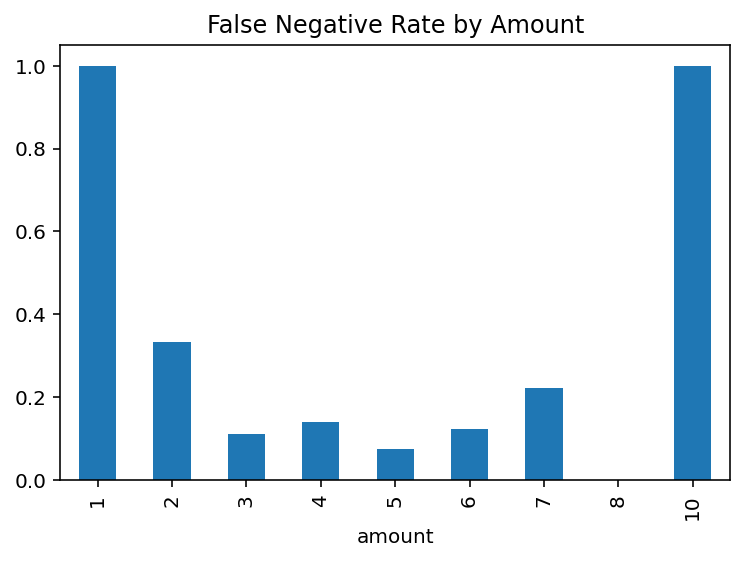

In [126]:
#Big trader (amount >= 3) vs small trader (amount <= 2)
from sklearn.preprocessing import Binarizer
from sklearn import metrics

#Binarizing the 'amount' column
b = Binarizer(threshold=2)
results = X_test.copy()
preds = grids.predict(X_test)
results['prediction'] = preds
results['party'] = y_test

#Need to binarize 'prediction' and 'party' columns to do analysis
#Democrat = 0/Negative, Republican =  1/Positive

results['prediction'] = results['prediction'].replace({'democrat':0,'republican':1})
results['party'] = results['party'].replace({'democrat':0,'republican':1})
results['is_big_trade'] = b.transform(results[['amount']])
results['is_big_trade'] = results['is_big_trade'].replace({1:'big_trade',0:'small_trade'})

(
    results
    .groupby('amount')
    .apply(lambda x : 1 - metrics.recall_score(x['party'], x['prediction']))
    .plot(kind = 'bar', title='False Negative Rate by Amount')
);



In [121]:
results.groupby('is_big_trade')['prediction'].mean().to_frame()
#This model does not achieve Demographic parity

,prediction
is_big_trade,
big_trade,0.70099
small_trade,0.40000


              accuracy
is_big_trade          
big_trade     0.800990
small_trade   0.721875
0.0049


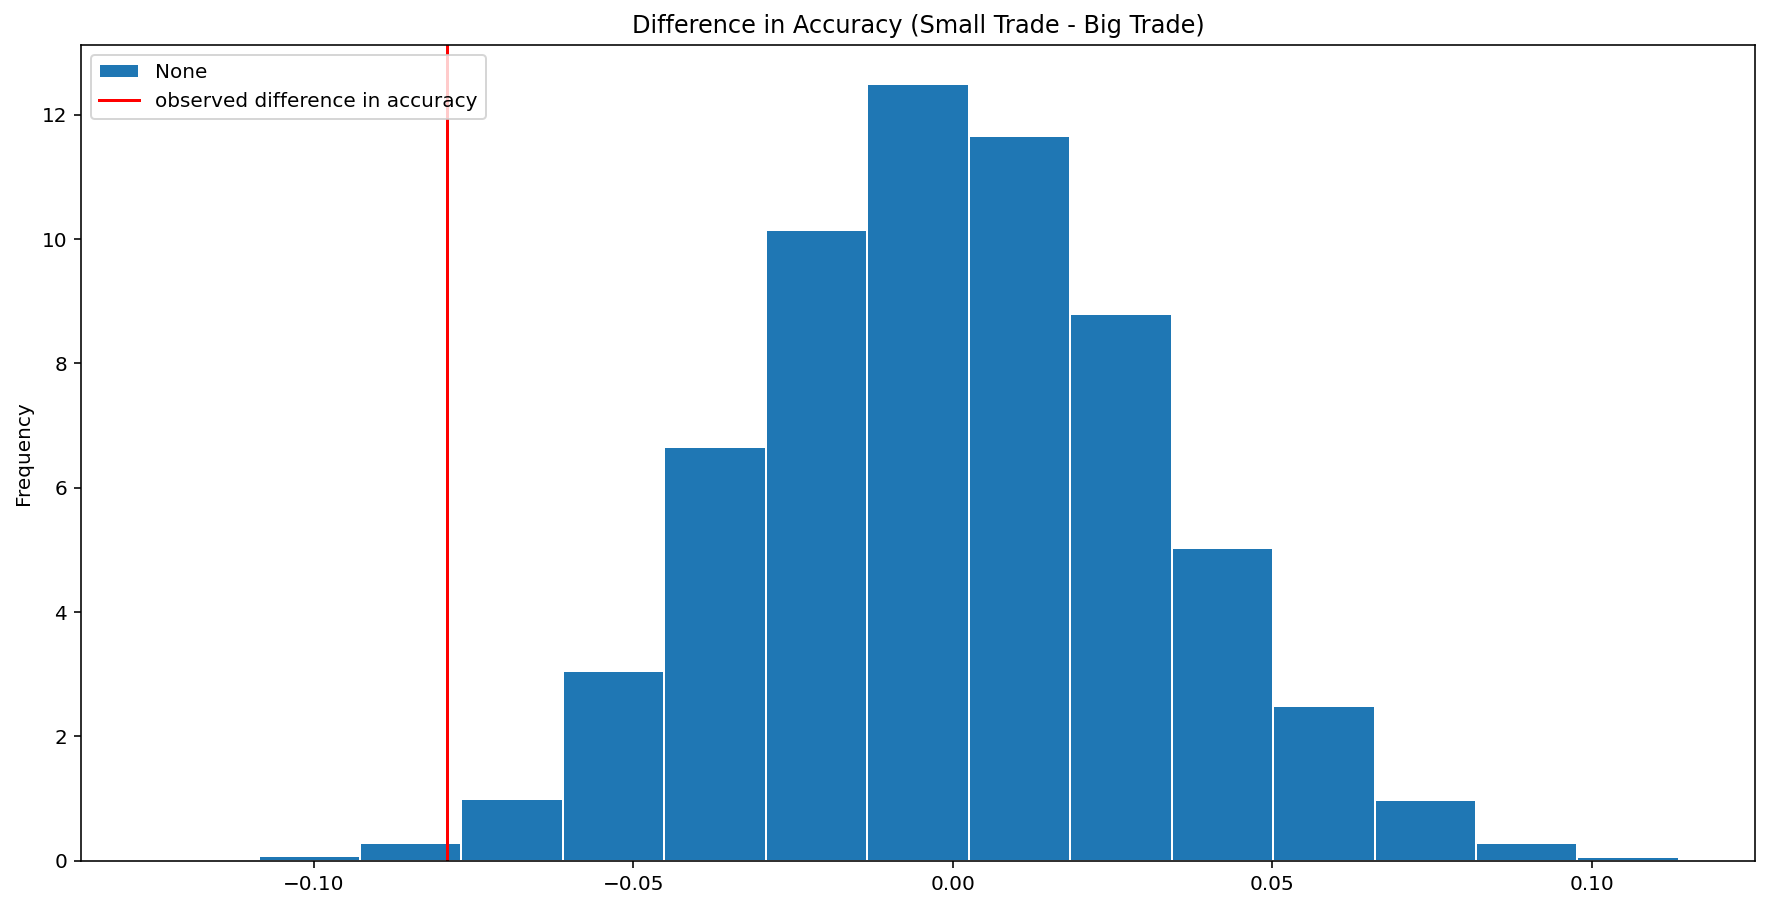

In [123]:
print(
    results
    .groupby('is_big_trade')
    .apply(lambda x: metrics.accuracy_score(x['party'], x['prediction']))
    .rename('accuracy')
    .to_frame()
)

#Getting observed accuracy
obs_acc = results.groupby('is_big_trade').apply(lambda x: metrics.accuracy_score(x['party'], x['prediction'])).diff().iloc[-1]


#Conductin permutation test
diffs = []
for _ in range(10000):
    a = (
        results[['is_big_trade', 'prediction', 'party']]
        .assign(is_big_trade=results.is_big_trade.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('is_big_trade')
        .apply(lambda x: metrics.accuracy_score(x['party'], x['prediction']))
        .diff()
        .iloc[-1]
    )
    
    diffs.append(a)
plt.figure(figsize=(15, 7.5))
pd.Series(diffs).plot(kind='hist', ec='w', density=True, bins=15, title='Difference in Accuracy (Small Trade - Big Trade)')
plt.axvline(x=obs_acc, color='red', label='observed difference in accuracy')
plt.legend(loc='upper left');
print((obs_acc > diffs).mean())
#Despite being a 7.9% difference in accuracy this is a significant difference based on the permutation test
#This model likely does not have accuracy parity.
#P-value of 0.0049 is below level of significance which is 0.01